# T5 fine tuning, cont.

In [ ]:
pip install transformers datasets torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
from datasets import load_dataset

# Loading the DialogSum dataset
dataset_ft = load_dataset("knkarthick/dialogsum")
train_dataset_ft = dataset_ft['train']
val_dataset = dataset_ft['validation']
test_dataset = dataset_ft['test']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/12460 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
from transformers import T5Tokenizer

# Loading the T5 tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")

def preprocess_function(records):
    inputs = ["summarize: " + dialogue for dialogue in records["dialogue"]]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")

    labels = tokenizer(records["summary"], max_length=150, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]

    return model_inputs

train_dataset = train_dataset_ft.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
from transformers import Seq2SeqTrainingArguments

# settingtraining arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=9.460705253161354e-05,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.005806214555009961,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    logging_dir='./logs',
    logging_steps=10,
    report_to="none"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import T5ForConditionalGeneration, Seq2SeqTrainer

model = T5ForConditionalGeneration.from_pretrained("t5-small")
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.378600,0.347110
2,0.427100,0.334530
3,0.357000,0.331938


TrainOutput(global_step=2337, training_loss=0.4235996088004286, metrics={'train_runtime': 1728.4123, 'train_samples_per_second': 21.627, 'train_steps_per_second': 1.352, 'total_flos': 5059076539023360.0, 'train_loss': 0.4235996088004286, 'epoch': 3.0})

In [ ]:
save_directory = "/content/fine-tuned-t5"
trainer.save_model(save_directory)
tokenizer.save_pretrained(save_directory)

('/content/fine-tuned-t5/tokenizer_config.json',
 '/content/fine-tuned-t5/special_tokens_map.json',
 '/content/fine-tuned-t5/spiece.model',
 '/content/fine-tuned-t5/added_tokens.json')

In [ ]:
import torch
torch.save(model.state_dict(), "fine-tuned-t5.pt")

In [ ]:
from transformers import T5ForConditionalGeneration

model =T5ForConditionalGeneration.from_pretrained("t5-small")
model.load_state_dict(torch.load("fine-tuned-t5.pt"))
model.eval()

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("t5-small")
def generate_summary(records):
    input_text = records['dialogue']
    input_ids = tokenizer.encode("summarize: " + input_text, return_tensors="pt", max_length=512, truncation=True)
    with torch.no_grad():
        output_ids = model.generate(input_ids, max_length=150, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return {"generated_summary": summary}
test_dataset_with_summaries = test_dataset.map(generate_summary)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=2a834c5bb1ef401a202f642042f19b5554a1f2f17dcfe7e0391acb03a0fb6705
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
!pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.3 MB/s eta 0:00:00


In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from bert_score import score as bert_score
import nltk
nltk.download('punkt')
nltk.download('wordnet')

def calculate_metrics(reference, hypothesis):
    metrics = {}

    # Tokenize reference and hypothesis for METEOR and BLEU
    reference_tokens = nltk.word_tokenize(reference)
    hypothesis_tokens = nltk.word_tokenize(hypothesis)

    smooth_fn = SmoothingFunction().method1
    metrics['BLEU'] = sentence_bleu([reference_tokens], hypothesis_tokens, smoothing_function=smooth_fn)
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference, hypothesis)
    metrics['ROUGE-1'] = rouge_scores['rouge1'].fmeasure
    metrics['ROUGE-2'] = rouge_scores['rouge2'].fmeasure
    metrics['ROUGE-L'] = rouge_scores['rougeL'].fmeasure
    metrics['METEOR'] = meteor_score([reference_tokens], hypothesis_tokens)
    '''
    # BERTScore
    P, R, F1 = bert_score([hypothesis], [reference], lang="en")
    metrics['BERTScore'] = F1.mean().item()
    '''
    # BERTScore
    P, R, F1 = bert_score([hypothesis], [reference], lang='en', model_type='bert-base-uncased', verbose=False)
    metrics['BERTScore_P'] = P.mean().item()
    metrics['BERTScore_R'] = R.mean().item()
    metrics['BERTScore_F1'] = F1.mean().item()
    #cosinesimilarity
    vectorizer = TfidfVectorizer().fit_transform([reference, hypothesis])
    vectors = vectorizer.toarray()
    cosine_sim = cosine_similarity(vectors)
    metrics['Cosine Similarity'] = cosine_sim[0, 1]

    return metrics

#metrics for the test dataset
test_results = test_dataset_with_summaries.map(
    lambda records: calculate_metrics(records['summary'], records['generated_summary'])
)

import pandas as pd
results_df = pd.DataFrame(test_results)
print(results_df[['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR', 'Cosine Similarity', 'BERTScore_P', 'BERTScore_R', 'BERTScore_F1']].describe())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

              BLEU      ROUGE-1      ROUGE-2      ROUGE-L       METEOR  \
count  1500.000000  1500.000000  1500.000000  1500.000000  1500.000000   
mean      0.132081     0.394689     0.139598     0.315524     0.417730   
std       0.107678     0.133360     0.129836     0.130717     0.142823   
min       0.000404     0.000000     0.000000     0.000000     0.039062   
25%       0.055067     0.303030     0.040816     0.222222     0.318742   
50%       0.095713     0.384615     0.117647     0.296296     0.406338   
75%       0.185220     0.476190     0.206897     0.387097     0.511160   
max       0.782542     0.941176     0.800000     0.941176     0.990560   

       Cosine Similarity  BERTScore_P  BERTScore_R  BERTScore_F1  
count        1500.000000  1500.000000  1500.000000   1500.000000  
mean            0.331937     0.684046     0.694603      0.687548  
std             0.134828     0.094455     0.081933      0.081948  
min             0.000000     0.359419     0.424138      0.389106 

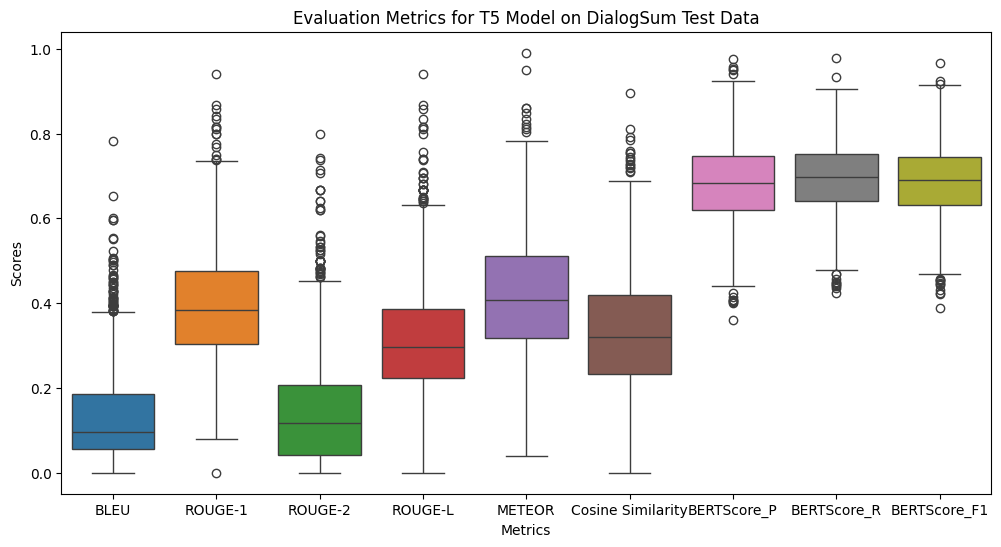

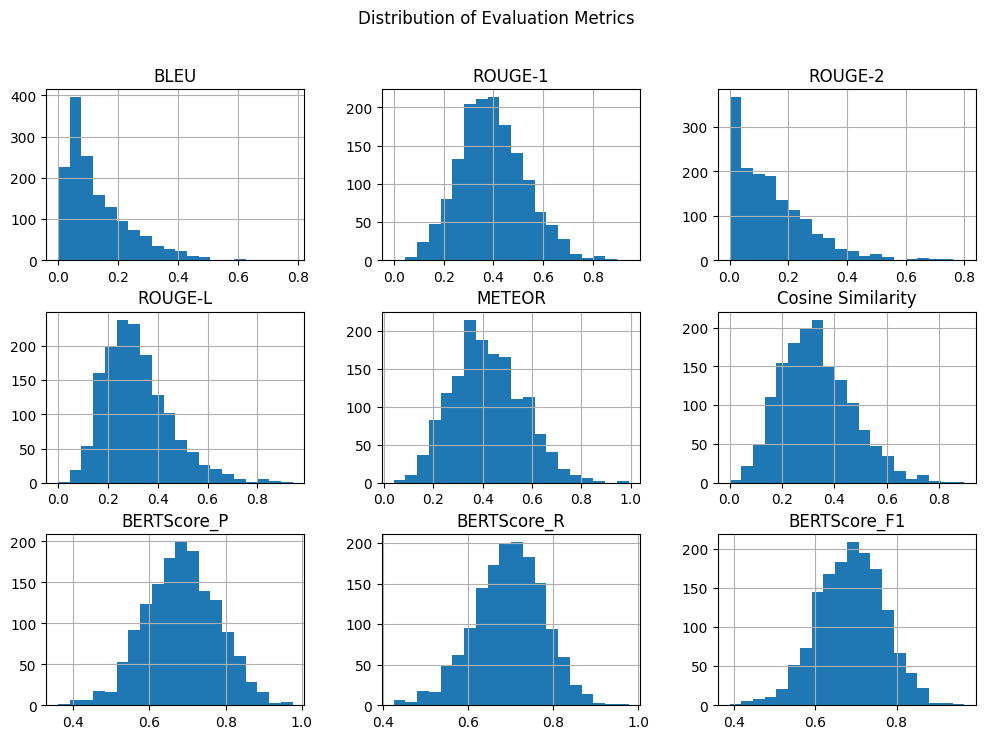

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df[['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR','Cosine Similarity','BERTScore_P', 'BERTScore_R', 'BERTScore_F1']])
plt.title('Evaluation Metrics for T5 Model on DialogSum Test Data')
plt.ylabel('Scores')
plt.xlabel('Metrics')
plt.show()

# Histogram
results_df[['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR','Cosine Similarity','BERTScore_P', 'BERTScore_R', 'BERTScore_F1']].hist(bins=20, figsize=(12, 8))
plt.suptitle('Distribution of Evaluation Metrics')
plt.show()


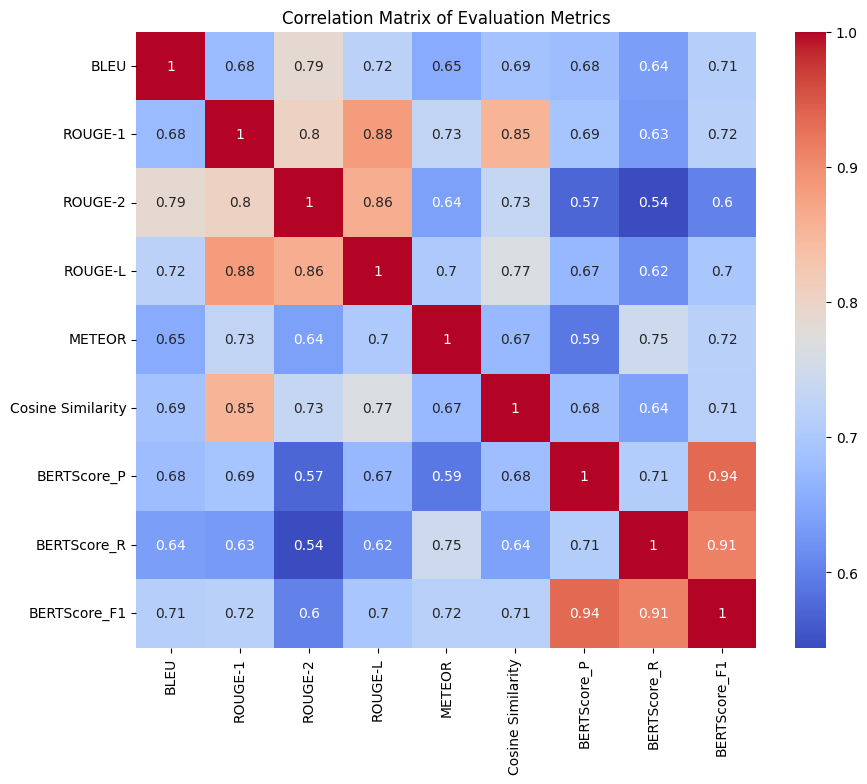

In [ ]:
#correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(results_df[['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR','Cosine Similarity','BERTScore_P', 'BERTScore_R', 'BERTScore_F1']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Evaluation Metrics')
plt.show()